# PMLBmini experiments

This notebook runs the PMLBmini experiments, and compares RANDOM FEATURE BOOSTING and END2END to the saved PMLBmini models

NOTE that we assume tabmini is installed in the cwd https://github.com/RicardoKnauer/TabMini 

Should take no more than 30 minutes to run this notebook, ie run all models and datasets sequentially on a single CPU core

In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import os
import pickle
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import pandas as pd
import tabmini
import aeon
from aeon.visualisation import plot_critical_difference, plot_significance
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from models.gridsearch_wrapper import SKLearnWrapper
from models.random_feature_representation_boosting import GradientRFRBoostClassifier
from models.end2end import End2EndMLPResNet

In [2]:
class Config:
    save_dir = Path.cwd() / "results" / "PMLBmini"

In [3]:
##############################################
#####      Equal/Random Guessing        ######
##############################################


class EqualGuessing(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        return self

    def predict_proba(self, X):
        """Guess probabilty 0.5 for each class"""
        # Guess [0.5, 0.5]
        return np.ones((X.shape[0], 2)) * 0.5

    def decision_function(self, X):
        # Get the probabilities from predict_proba
        proba = self.predict_proba(X)
        # Calculate the log of ratios for binary classification
        decision = np.log((proba[:, 1] + 1e-10) / (proba[:, 0] + 1e-10))
        return decision
    

##################################################
############# Grid Search wrapper    #############
############# for custom estimators  #############
##################################################


class WrapperGridSearch(BaseEstimator, ClassifierMixin):
    def __init__(self, param_grid:Dict[str, List], out_name = "n_classes"):
        self.param_grid = param_grid
        self.out_name = out_name # 'n_classes' for GBRFRBoost, 'out_dim' for E2E_MLP_ResNet


    def fit(self, X, y):
        """
        Performs a stratified 3-fold CV for hyperparameter tuning
        based on self.param_grid, and fits the best model on the whole dataset
        """
        # MinMaxScaler and convert to torch
        self.classes_ = np.unique(y)
        N, D = X.values.shape
        self.scaler = MinMaxScaler()
        X = self.scaler.fit_transform(X.values)
        X = torch.tensor(X).float()
        y = torch.tensor(y.values)[..., None].float()

        # Perform grid search with k-fold cross-validation
        param_grid = {**self.param_grid, **{"seed": [42]}, **{"in_dim": [D]}, **{self.out_name: [2]}}
        if self.out_name == 'out_dim': # end2end has other param names
            param_grid["batch_size"] = [max(int(N*4/9-1), self.param_grid["batch_size"][0])] # otherwise we can get a batch size of 1, error with batch norm
            param_grid[self.out_name] = [1]
        estimator = SKLearnWrapper()
        grid_search = GridSearchCV(
            estimator=estimator,
            param_grid= param_grid,
            cv=StratifiedKFold(n_splits=3), #3-fold since PMLBmini uses 3-fold
            verbose=1,
        )
        grid_search.fit(X, y)

        # fit best model
        best_model = grid_search.best_estimator_
        print("Best params:", grid_search.best_params_)
        best_model.set_model_eval()
        self.model = best_model
        return self


    def predict_proba(self, X):
        X = self.scaler.fit_transform(X.values)
        X = torch.tensor(X).float()
        proba_0 = torch.nn.functional.sigmoid(self.model.predict(X)).cpu().detach().numpy()
        return np.concatenate((1 - proba_0, proba_0), axis=1)


    def decision_function(self, X):
        proba = self.predict_proba(X)
        decision = np.log((proba[:, 1] + 1e-10) / (proba[:, 0] + 1e-10))
        return decision

In [4]:
#########################
#### Run given model ####
#########################

def test_on_PMLBmini(
        estimator: BaseEstimator,
        estimator_name: str, 
        dataset_save_path = Config.save_dir / 'PMLBmini_dataset.pkl',
        other_saved_methods = {}, #{'XGBoost'},
        ):
    
    #download dataset, cache it
    if not os.path.exists(dataset_save_path):
        print("Dataset not found, downloading")
        dataset = tabmini.load_dataset(reduced=False)
        os.makedirs(Config.save_dir, exist_ok=True)
        with open(dataset_save_path, 'wb') as f:
            pickle.dump(dataset, f)
    else:
        print("Dataset found, loading")
        with open(dataset_save_path, 'rb') as f:
            dataset = pickle.load(f)

    # Perform the comparison
    train_results, test_results = tabmini.compare(
        estimator_name,
        estimator,
        dataset,
        working_directory = Config.save_dir,
        scoring_method="roc_auc",
        methods= {},
        cv=3,
        time_limit=3600,
        device="cpu",
        n_jobs=1,
    )
    return train_results, test_results

In [5]:
train_guessing_and_xgboost, test_guessing_and_xgboost = test_on_PMLBmini(
    EqualGuessing(),
    'EqualGuessing',
    other_saved_methods={"XGBoost"},
    )

Dataset found, loading
Evaluating EqualGuessing against {}...
Comparing EqualGuessing on analcatdata_aids
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing EqualGuessing
Comparing EqualGuessing on analcatdata_asbestos
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing EqualGuessing
Comparing EqualGuessing on analcatdata_bankruptcy
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated

In [6]:
# train_logistic, test_logistic = test_on_PMLBmini(
#     WrapperGridSearch(param_grid = {
#                 'modelClass': [GradientRFRBoostClassifier],
#                 'l2_cls': [1, 0.1, 0.001, 0.0001],
#                 'n_layers': [0],
#                 'upscale_type': ["identity"],
#                 'use_batchnorm': [False],
#                 'lbfgs_max_iter': [300],
#                 'lbfgs_lr': [1.0],
#             }),
#     'Logistic (mine)',
#     )

In [ ]:
# TODO fix this tomorrow... TODO TODO TODO TODO maybe enable batch norm and do grid search

In [ ]:
# train_GRFRBoost_exp, test_GRFRBoost_exp = test_on_PMLBmini(
#     WrapperGridSearch(param_grid = {
#                 'modelClass': [GradientRFRBoostClassifier],
#                 'l2_cls': [0.001],
#                 'l2_ghat': [0.01],
#                 'n_layers': [2],
#                 'randfeat_xt_dim': [512],
#                 'randfeat_x0_dim': [512],
#                 'hidden_dim': [128],
#                 # 'SWIM_scale': [1.0],
#                 'use_batchnorm': [False],
#             }),
#     'GRFRBoost exp',
#     other_saved_methods={},
#     )

In [12]:
train_GRFRBoost, test_GRFRBoost = test_on_PMLBmini(
    WrapperGridSearch(param_grid = {
                'modelClass': [GradientRFRBoostClassifier],
                'l2_cls': [0.001],
                'l2_ghat': [0.001],
                'n_layers': [2],
                'randfeat_xt_dim': [512],
                'randfeat_x0_dim': [512],
                'hidden_dim': [128],
                # 'SWIM_scale': [1.0],
                'use_batchnorm': [False],
            }),
    'GRFRBoost (ours)',
    other_saved_methods={},
    )

Dataset found, loading
Evaluating GRFRBoost (ours) against {}...
Comparing GRFRBoost (ours) on analcatdata_aids
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing GRFRBoost (ours)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best params: {'hidden_dim': 128, 'in_dim': 4, 'l2_cls': 0.001, 'l2_ghat': 0.001, 'modelClass': <class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier'>, 'n_classes': 2, 'n_layers': 2, 'randfeat_x0_dim': 512, 'randfeat_xt_dim': 512, 'seed': 42, 'use_batchnorm': False}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best params: {'hidden_dim': 128, 'in_dim': 4, 'l2_cls': 0.001, 'l2_ghat': 0.001, 'modelClass': <class 'models.random_feature_representation_boosti

In [13]:
# Random feature Neural Network
train_RFNN, test_RFNN = test_on_PMLBmini(
    WrapperGridSearch(param_grid = {
                'modelClass': [GradientRFRBoostClassifier],
                'l2_cls': [1, 0.1, 0.001, 0.0001],
                'hidden_dim': [128],
                'n_layers': [0],
            }),
    'RFNN',
    other_saved_methods={},
    )

Dataset found, loading
Evaluating RFNN against {}...
Comparing RFNN on analcatdata_aids
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing RFNN
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'hidden_dim': 128, 'in_dim': 4, 'l2_cls': 0.0001, 'modelClass': <class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier'>, 'n_classes': 2, 'n_layers': 0, 'seed': 42}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'hidden_dim': 128, 'in_dim': 4, 'l2_cls': 0.001, 'modelClass': <class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier'>, 'n_classes': 2, 'n_layers': 0, 'seed': 42}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best 

In [14]:
train_E2E, test_E2E = test_on_PMLBmini(
    WrapperGridSearch(param_grid = {
            'modelClass': [End2EndMLPResNet],
            'lr': np.logspace(-6, -2, 5),
            'hidden_dim': [128],
            'bottleneck_dim': [512],
            'n_blocks': [2],
            'loss': ["bce"],
            'n_epochs': [30],
            'end_lr_factor': [0.01],
            'weight_decay': [0.00001],
            'batch_size': [64],
            'activation': [nn.ReLU()],
            },
            out_name='out_dim',),
    'E2E_MLP_ResNet',
    other_saved_methods={},
    )

Dataset found, loading
Evaluating E2E_MLP_ResNet against {}...
Comparing E2E_MLP_ResNet on analcatdata_aids
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 4, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 4, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 4, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on analcatdata_asbestos
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 3, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 3, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 3, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on analcatdata_bankruptcy
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 6, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 6, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 6, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on analcatdata_creditscore
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 6, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 6, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 6, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on analcatdata_cyyoung8092
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 10, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 10, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 10, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on analcatdata_cyyoung9302
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 10, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 10, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 10, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on analcatdata_fraud
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 11, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 11, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 11, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on analcatdata_japansolvent
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 9, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 9, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 9, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on labor
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 16, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 16, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 16, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on lupus
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 3, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 3, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 3, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on parity5
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 5, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 5, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 5, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on postoperative_patient_data
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 8, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 8, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 8, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on analcatdata_boxing1
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 3, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 3, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 3, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on analcatdata_boxing2
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 3, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 3, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 3, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on appendicitis
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 7, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 7, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 7, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on backache
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 172.24it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 32, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 93.40it/s] 


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 32, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 158.42it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 32, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on corral
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 139.27it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 6, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 157.89it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 6, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 162.43it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 6, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on glass2
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 153.44it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 9, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 169.68it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 9, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 143.49it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 9, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on hepatitis
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 140.03it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 19, 'loss': 'bce', 'lr': 1e-05, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 121.78it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 19, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 153.92it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 19, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on molecular_biology_promoters
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 57, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 57, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 57, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on mux6
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 6, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 6, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https:

Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 6, 'loss': 'bce', 'lr': 1e-06, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on prnn_crabs
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 74.46it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 7, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 66.81it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 7, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 65.20it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 7, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on analcatdata_lawsuit
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 65.99it/s]


Best params: {'activation': ReLU(), 'batch_size': 77, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 4, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 65.41it/s]


Best params: {'activation': ReLU(), 'batch_size': 77, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 4, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 77.85it/s]


Best params: {'activation': ReLU(), 'batch_size': 77, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 4, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on biomed
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 72.77it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 8, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 78.16it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 8, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 58.95it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 8, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on breast_cancer
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 73.06it/s]


Best params: {'activation': ReLU(), 'batch_size': 83, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 9, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 74.87it/s]


Best params: {'activation': ReLU(), 'batch_size': 83, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 9, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 67.05it/s]


Best params: {'activation': ReLU(), 'batch_size': 83, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 9, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on heart_h
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 57.61it/s]


Best params: {'activation': ReLU(), 'batch_size': 86, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 13, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 66.10it/s]


Best params: {'activation': ReLU(), 'batch_size': 86, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 13, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 66.10it/s]


Best params: {'activation': ReLU(), 'batch_size': 86, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 13, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on heart_statlog
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 80.00it/s]


Best params: {'activation': ReLU(), 'batch_size': 79, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 13, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 80.01it/s]


Best params: {'activation': ReLU(), 'batch_size': 79, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 13, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 71.85it/s]


Best params: {'activation': ReLU(), 'batch_size': 79, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 13, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on hungarian
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 70.92it/s]


Best params: {'activation': ReLU(), 'batch_size': 86, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 13, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 75.18it/s]


Best params: {'activation': ReLU(), 'batch_size': 86, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 13, 'loss': 'bce', 'lr': 1e-05, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 85.61it/s]


Best params: {'activation': ReLU(), 'batch_size': 86, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 13, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on prnn_synth
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 70.33it/s]


Best params: {'activation': ReLU(), 'batch_size': 72, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 2, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 86.28it/s]


Best params: {'activation': ReLU(), 'batch_size': 73, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 2, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 88.74it/s]


Best params: {'activation': ReLU(), 'batch_size': 73, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 2, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on sonar
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 92.20it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 60, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 86.60it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 60, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 93.63it/s]


Best params: {'activation': ReLU(), 'batch_size': 64, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 60, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on spect
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 88.22it/s]


Best params: {'activation': ReLU(), 'batch_size': 78, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 22, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 77.89it/s]


Best params: {'activation': ReLU(), 'batch_size': 78, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 22, 'loss': 'bce', 'lr': 1e-05, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 73.78it/s]


Best params: {'activation': ReLU(), 'batch_size': 78, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 22, 'loss': 'bce', 'lr': 1e-05, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on bupa
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 78.57it/s]


Best params: {'activation': ReLU(), 'batch_size': 101, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 5, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 80.23it/s]


Best params: {'activation': ReLU(), 'batch_size': 101, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 5, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 71.89it/s]


Best params: {'activation': ReLU(), 'batch_size': 101, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 5, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on cleve
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 65.10it/s]


Best params: {'activation': ReLU(), 'batch_size': 88, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 13, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 69.30it/s]


Best params: {'activation': ReLU(), 'batch_size': 88, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 13, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 50.62it/s]


Best params: {'activation': ReLU(), 'batch_size': 88, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 13, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on colic
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 66.86it/s]


Best params: {'activation': ReLU(), 'batch_size': 107, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 22, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 60.43it/s]


Best params: {'activation': ReLU(), 'batch_size': 107, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 22, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 61.20it/s]


Best params: {'activation': ReLU(), 'batch_size': 108, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 22, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on haberman
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 65.49it/s]


Best params: {'activation': ReLU(), 'batch_size': 89, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 3, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 69.06it/s]


Best params: {'activation': ReLU(), 'batch_size': 89, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 3, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 69.89it/s]


Best params: {'activation': ReLU(), 'batch_size': 89, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 3, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on heart_c
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 80.75it/s]


Best params: {'activation': ReLU(), 'batch_size': 88, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 13, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 83.15it/s]


Best params: {'activation': ReLU(), 'batch_size': 88, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 13, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 73.19it/s]


Best params: {'activation': ReLU(), 'batch_size': 88, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 13, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on horse_colic
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 49.73it/s]


Best params: {'activation': ReLU(), 'batch_size': 107, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 22, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 65.86it/s]


Best params: {'activation': ReLU(), 'batch_size': 107, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 22, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 41.75it/s]


Best params: {'activation': ReLU(), 'batch_size': 108, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 22, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on ionosphere
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 60.89it/s]


Best params: {'activation': ReLU(), 'batch_size': 103, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 34, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 61.00it/s]


Best params: {'activation': ReLU(), 'batch_size': 103, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 34, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 86.01it/s]


Best params: {'activation': ReLU(), 'batch_size': 103, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 34, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on spectf
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 84.58it/s]


Best params: {'activation': ReLU(), 'batch_size': 102, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 44, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 73.70it/s]


Best params: {'activation': ReLU(), 'batch_size': 102, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 44, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 85.96it/s]


Best params: {'activation': ReLU(), 'batch_size': 102, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 44, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on clean1
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 77.12it/s]


Best params: {'activation': ReLU(), 'batch_size': 139, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 168, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 77.27it/s]


Best params: {'activation': ReLU(), 'batch_size': 139, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 168, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 71.75it/s]


Best params: {'activation': ReLU(), 'batch_size': 140, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 168, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on house_votes_84
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 75.62it/s]


Best params: {'activation': ReLU(), 'batch_size': 127, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 16, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 76.94it/s]


Best params: {'activation': ReLU(), 'batch_size': 127, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 16, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 69.06it/s]


Best params: {'activation': ReLU(), 'batch_size': 127, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 16, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on irish
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 72.73it/s]


Best params: {'activation': ReLU(), 'batch_size': 147, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 5, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 50.24it/s]


Best params: {'activation': ReLU(), 'batch_size': 147, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 5, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 63.58it/s]


Best params: {'activation': ReLU(), 'batch_size': 147, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 5, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on saheart
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 63.44it/s]


Best params: {'activation': ReLU(), 'batch_size': 135, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 9, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 62.39it/s]


Best params: {'activation': ReLU(), 'batch_size': 135, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 9, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 55.46it/s]


Best params: {'activation': ReLU(), 'batch_size': 135, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 9, 'loss': 'bce', 'lr': 0.0001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Comparing E2E_MLP_ResNet on vote
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing E2E_MLP_ResNet
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 49.40it/s]


Best params: {'activation': ReLU(), 'batch_size': 127, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 16, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 59.40it/s]


Best params: {'activation': ReLU(), 'batch_size': 127, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 16, 'loss': 'bce', 'lr': 0.01, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


100%|██████████| 30/30 [00:00<00:00, 67.41it/s]

Best params: {'activation': ReLU(), 'batch_size': 127, 'bottleneck_dim': 512, 'end_lr_factor': 0.01, 'hidden_dim': 128, 'in_dim': 16, 'loss': 'bce', 'lr': 0.001, 'modelClass': <class 'models.end2end.End2EndMLPResNet'>, 'n_blocks': 2, 'n_epochs': 30, 'out_dim': 1, 'seed': 42, 'weight_decay': 1e-05}
Extracting test and train scores


In [15]:
# Load the CSV and set the index
saved_results = pd.read_csv('https://raw.githubusercontent.com/RicardoKnauer/TabMini/master/plotting/results/test_scores_wide_3600.csv', delimiter=";", index_col=0)
saved_results.index.name = None
saved_results

,AutoPrognosis,AutoGluon,TabPFN,Logistic regression,HyperFast
parity5,0.27,1.00,0.02,0.17,0.02
analcatdata_fraud,0.86,0.80,0.79,0.77,0.73
analcatdata_aids,0.73,0.77,0.63,0.61,0.53
analcatdata_bankruptcy,0.98,0.98,0.96,0.97,0.88
analcatdata_japansolvent,0.85,0.88,0.91,0.85,0.91
labor,0.88,0.94,0.99,0.97,0.98
analcatdata_asbestos,0.87,0.84,0.85,0.86,0.87
lupus,0.84,0.79,0.82,0.85,0.79
postoperative_patient_data,0.49,0.55,0.44,0.38,0.34
analcatdata_cyyoung9302,0.89,0.85,0.87,0.87,0.84


In [16]:
combined_results = saved_results.copy()
# combined_results = pd.read_csv(Config.save_dir / "combined_results.csv", index_col=0)
for df in [test_guessing_and_xgboost, 
           test_RFNN, 
           test_E2E, 
           test_GRFRBoost,
           ]:
    combined_results = combined_results.join(df, how='inner')
combined_results = combined_results.round(2) # since PMLBmini's resulst are rounded to 2 decimals, for fair comparison
combined_results

#save
combined_results.to_csv(Config.save_dir / "combined_results.csv")


In [17]:
combined_results = pd.read_csv(Config.save_dir / "combined_results.csv", index_col=0)
combined_results

,AutoPrognosis,AutoGluon,TabPFN,Logistic regression,HyperFast,EqualGuessing,RFNN,E2E_MLP_ResNet,GRFRBoost (ours)
parity5,0.27,1.00,0.02,0.17,0.02,0.5,0.75,0.50,1.00
analcatdata_fraud,0.86,0.80,0.79,0.77,0.73,0.5,0.88,0.62,1.00
analcatdata_aids,0.73,0.77,0.63,0.61,0.53,0.5,0.82,0.29,1.00
analcatdata_bankruptcy,0.98,0.98,0.96,0.97,0.88,0.5,0.99,0.07,1.00
analcatdata_japansolvent,0.85,0.88,0.91,0.85,0.91,0.5,0.95,0.66,1.00
labor,0.88,0.94,0.99,0.97,0.98,0.5,1.00,0.35,1.00
analcatdata_asbestos,0.87,0.84,0.85,0.86,0.87,0.5,0.86,0.28,1.00
lupus,0.84,0.79,0.82,0.85,0.79,0.5,0.85,0.67,1.00
postoperative_patient_data,0.49,0.55,0.44,0.38,0.34,0.5,0.77,0.53,0.99
analcatdata_cyyoung9302,0.89,0.85,0.87,0.87,0.84,0.5,0.92,0.38,1.00


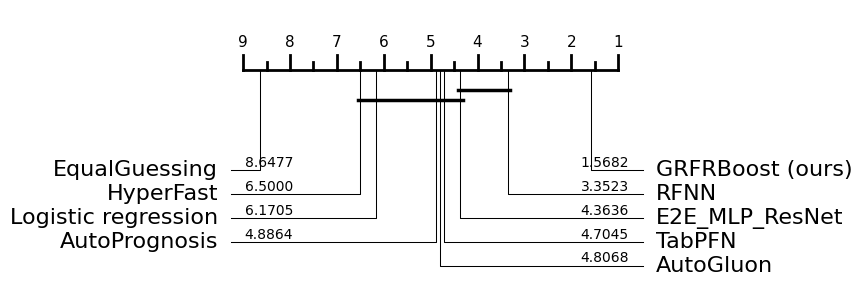

In [19]:
plot = plot_critical_difference(combined_results.values,
                                combined_results.columns.tolist(), 
                                alpha=0.05, 
                                lower_better=False)
plot[0].savefig(Config.save_dir / "PMLBmini_critical_difference.eps")

In [ ]:
# TODO do i want an AUC plot? table? or just the critical difference plot?



# TODO YES I WANT TABLE LIKE CONCENTRIC CIRCLES
